# Introduction to [JAX](https://github.com/google/jax) 
# Accelerator-oriented array computation and program transformation

<div align="center"><img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo.svg" width="400"/></div>

In [4]:
from timers import cpu_timer

## NumPy functionality with JAX

In [5]:
import os
import numpy as np
import jax.numpy as jnp
import jax

In [6]:
x = jnp.arange(10)
y = jnp.arange(10, 20)
z = x + y

#### Euclidean distance matrix

$
    d_e(\mathbf x, \mathbf y) =
    \begin{bmatrix}
    \sum_{i=1}^n (x_{1i}-y_{1i})^2 & \sum_{i=1}^n(x_{1i}-y_{2i})^2 & \cdots & \sum_{i=1}^n (x_{1i}-y_{ni})^2 \\  
    \sum_{i=1}^n(x_{2i}-y_{1i})^2 & \sum_{i=1}^n(x_{2i}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{2i}-y_{ni})^2 \\  
    \vdots & \vdots & \ddots & \vdots \\
    \sum_{i=1}^n(x_{ni}-y_{1i})^2 & \sum_{i=1}^n(x_{ni}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{ni}-y_{ni})^2 \\  
    \end{bmatrix}
$

#### Vectorization friendly summation 
$ 
\sum_{k=1}^n \left(x_{ik}-y_{jk}\right)^2 = \left(\vec{x_i} - \vec {y_j}\right)\cdot \left(\vec{x_i} - \vec{y_j}\right)=\vec{x_i} \cdot \vec{x_i} + \vec{y_j} \cdot \vec{y_j} -2\vec{x_i}\cdot \vec{y_j}$


In [7]:
def euclidean_distance_cpu(x, y):
    x2 = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    y2 = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    xy = x @ y.T
    return np.abs(x2 + y2 - 2.0 * xy)

@jax.jit
def euclidean_distance_jax(x, y):
    x2 = jnp.einsum('ij,ij->i', x, x)[:, jnp.newaxis]
    y2 = jnp.einsum('ij,ij->i', y, y)[jnp.newaxis, :]
    xy = x @ y.T
    return jnp.abs(x2 + y2 - 2.0 * xy)

In [8]:
np_rng = np.random.default_rng()
x_cpu = np_rng.random((5000, 4000), dtype=np.float32)
y_cpu = np_rng.random((5000, 4000), dtype=np.float32)

x_gpu = jax.device_put(x_cpu).block_until_ready()
y_gpu = jax.device_put(y_cpu).block_until_ready()

with cpu_timer():
    eu_cpu = euclidean_distance_cpu(x_cpu, y_cpu)

with cpu_timer():
    eu_jax = euclidean_distance_jax(x_gpu, y_gpu).block_until_ready()
    
    
assert np.allclose(eu_cpu, jax.device_get(eu_jax), rtol=1e-04)

AssertionError: 

In [9]:
A = jnp.array([1., 2., 3., 4.])
B = jnp.array([2., 3., 4., 5.])

# This is not allowed
#A[2] = 10.0

A.at[2].set(10.0)

Array([ 1.,  2., 10.,  4.], dtype=float32)

In [ ]:
print(A)

### Random number generation

In [10]:
key = jax.random.key(0)
x = jax.random.uniform(key, (2, 2))
y = jax.random.uniform(key,(2, 2))
print(x)
print(y)

[[0.947667   0.9785799 ]
 [0.33229148 0.46866846]]
[[0.947667   0.9785799 ]
 [0.33229148 0.46866846]]


In [11]:
key = jax.random.key(0)
key, subkey = jax.random.split(key)

x = jax.random.uniform(key, (2, 2))
y = jax.random.uniform(subkey, (2, 2))
print(x)
print(y)

[[0.8423141  0.18237865]
 [0.2271781  0.12072563]]
[[0.00729382 0.02089119]
 [0.5814265  0.36183798]]


In [12]:
x = jnp.array([1., 2])

In [13]:
x.devices()

{CudaDevice(id=0)}

### Scaled Exponential Linear Unit (SELU) [Klambauer et al., 2017](https://arxiv.org/abs/1706.02515)


$$
f(x) =  \left\{
\begin{array}{ll}
      \lambda x & if & x \gt 0 \\
      \lambda \alpha (e^x - 1) & if & x \le 0 
\end{array} \right.
$$

$$
\begin{array}{ll}
    \alpha \simeq 1.67326 \\
    \lambda \simeq 1.050701
\end{array}
$$

SELU Cpu: SELU JAX: 

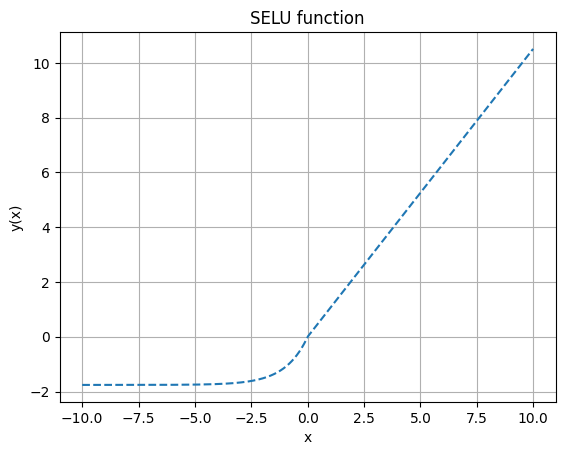

In [14]:
import matplotlib.pyplot as plt

from math import erfc, sqrt, exp, pi, e
x_cpu = np.linspace(-10.0, 10.0, 10_000_000)


alpha =  - sqrt(2.0 / pi) / (erfc(1 / sqrt(2)) * exp(1/2) - 1)
scale = (
    (1 - erfc(1 / sqrt(2)) * sqrt(e)) * sqrt(2 * pi) / 
    sqrt(2 * erfc(sqrt(2)) * e ** 2 + pi * e * erfc(1/sqrt(2)) ** 2 
         - 2 * (2 + pi)* erfc(1 / sqrt(2))*sqrt(e) + pi + 2)
)

def selu_cpu(x, a=alpha, l=scale):
    return np.where(x > 0, l * x, l * (a * np.exp(x) - a))

print('SELU Cpu: ', end='')
with cpu_timer():
    s_cpu = selu_cpu(x_cpu)
    
def selu_jax(x, a=alpha, l=scale):
    return jnp.where(x > 0, l * x, l * (a * jnp.exp(x) - a))

x_jax = jnp.linspace(-10., 10., 10_000_000)

print('SELU JAX: ', end='')
with cpu_timer():
    s_jax = selu_jax(x_jax).block_until_ready()

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_cpu, s_cpu, '--');
ax.set_title('SELU function', )
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.grid('Both');

### (Exercise) Do the same with JAX and measure the performance

In [15]:
def fun1(x):
    return x ** 2 + 10 * jnp.sin(x) + jnp.exp(x/10)

In [16]:
import jax

In [17]:
x = jnp.linspace(-10, 10, 100)

In [18]:
y = fun1(x)
y1 = jax.grad(fun1)
y2 = jax.grad(y1)

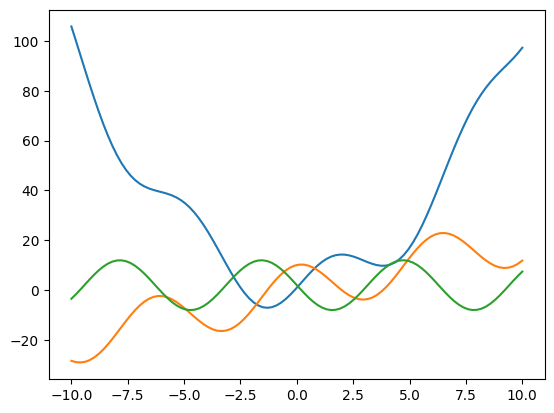

In [19]:
plt.plot(x, y)
plt.plot(x, jax.vmap(y1)(x))
plt.plot(x, jax.vmap(y2)(x))

## Controlling memory allocation

In [ ]:
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

## 64-bit Floating Point computations

In [ ]:
#os.environ['JAX_ENABLE_X64']='True'